<a href="https://colab.research.google.com/github/shivendrra/SmallLanguageModel-project/blob/main/Demo%20Models/Colab%20Notebooks/GPT_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing the data
file_path = '/content/drive/MyDrive/more_data.txt'
with open(file_path, 'r', encoding='utf-8') as file:
  data = file.read()
total_no_of_words = len(data)
print(f"{total_no_of_words/1e6} million words")

397.043001 million words


In [3]:
# total no of chars and vocab size
chars = sorted(list(set(data)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¥§©«¬­®°±²³´µ·»¼½ÀÁÃÄÅÈÉÍÎÏÓÔÖ×ÙÜßàáâãäåæçèéêëìíîïñòóôõöøùúûüāăĄąĆćČĐęğīİŁłńōœŚśūźŻżʖʻʼ̴̵̶̷̸̡̢̧̨̛̖̗̘̙̜̝̞̟̠̣̤̥̦̩̪̫̬̭̮̯̰̱̲̳̹̺̻̼͇͈͉͍͎͓͔͕͖͙͚̀́̂̃̄̅̆̇̈̉̊̋̌̍̎̏̐̑̒̓̔̽̾̿̀́͂̓̈́͆͊͋͌͐͑͒͗͛̕̚͘͜͝͠͡ͅ͵΄ΆΈΉΊΌΎΐΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩΪάέήίαβγδεζηθικλμνξοπρςστυφχψωϊόύώϑДабрсಠἀἁἂἃἄἅἈἉἊἋἌἍἐἑἔἕἘἙἜἝἠἡἢἣἤἥἦἧἨἩἪἫἬἭἮἯἰἱἴἵἶἷἸἹἼἽἾἿὀὁὃὄὅὈὉὋὌὍὐὑὔὕὖὗὙὝὟὠὡὥὦὧὩὭὮὯὰὲὴὶὸὺὼᾧᾳᾶᾷᾺ᾽᾿ῃῆῇῈῊῖῚῤῥῦῬῳῴῶῷῸῺ ​‍–—―‘’‚“”„•… ›‽⁠₂€₹™⅓⅔∆−≈⍵■□▲►▼◄♦♩♪♫♬♭⚡✓✨。えァアウェオサシジスッデトナニビフブボメョリルロンー一万写動千夜如宇宏开忽春来树梨活真花萌风꞉️﻿，ａｄｅｇｈｉｍｎｒｔｕｖｙ�𝅘𝅥𝅮𝔻𝕄𝕌𝕐𝕒𝕓𝕔𝕕𝕖𝕗𝕘𝕙𝕚𝕛𝕜𝕝𝕞𝕟𝕠𝕡𝕢𝕣𝕤𝕥𝕦𝕧𝕨𝕪𝘐𝘢𝘣𝘤𝘥𝘦𝘧𝘩𝘪𝘭𝘮𝘯𝘰𝘱𝘳𝘴𝘵𝘶𝘸𝘺🔮🤔
622


In [4]:
# train-test split

n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [5]:
print(f"train data {len(train_data)}, val data {len(val_data)}")

train data 357338700, val data 39704301


In [6]:
import timeit
start_time = timeit.default_timer()

In [7]:
# encoder and decoder of the text
string_to_index = { ch:i for i,ch in enumerate(chars) }
index_to_string = { i:ch for i,ch in enumerate(chars) }

encode = lambda s: [string_to_index[c] for c in s]
decode = lambda l: ''.join([index_to_string[i] for i in l])

print(encode('hello there'))
print(decode(encode('hello there')))

[73, 70, 77, 77, 80, 1, 85, 73, 70, 83, 70]
hello there


In [8]:
import torch

# Convert to tensors
train_data = torch.tensor(encode(train_data), dtype=torch.long)
val_data = torch.tensor(encode(val_data), dtype=torch.long)

In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # independent sequences process in parallel
block_size = 384 # maximum context length for predictions
max_iters = 20000
eval_interval = 1000
learning_rate = 3e-6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 450
n_head = 8
n_layer = 10
dropout = 0.2
# ------------

torch.manual_seed(1400)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
n_param = sum(p.numel() for p in m.parameters())/1e6
print(n_param, 'million')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Store step and loss values for visualization
        steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

25.043122 million
step 0: train loss 6.4854, val loss 6.4662
step 1000: train loss 3.0239, val loss 3.0528
step 2000: train loss 2.7007, val loss 2.7195
step 3000: train loss 2.5742, val loss 2.5973
step 4000: train loss 2.5118, val loss 2.5408
step 5000: train loss 2.4748, val loss 2.5067
step 6000: train loss 2.4522, val loss 2.4779
step 7000: train loss 2.4306, val loss 2.4533
step 8000: train loss 2.4072, val loss 2.4313
step 9000: train loss 2.3689, val loss 2.3984
step 10000: train loss 2.3039, val loss 2.3325
step 11000: train loss 2.2386, val loss 2.2727
step 12000: train loss 2.1980, val loss 2.2301
step 13000: train loss 2.1486, val loss 2.1828
step 14000: train loss 2.1096, val loss 2.1299
step 14999: train loss 2.0685, val loss 2.0851


In [13]:
run_time = timeit.default_timer()
total_time = run_time - start_time

In [14]:
input_from_user = "people often lie about themselves but"
token_input = encode(input_from_user)

In [15]:
# generate from the model
context = torch.tensor([token_input], dtype=torch.long, device=device)
generated_output = decode(m.generate(context, max_new_tokens=400)[0].tolist())

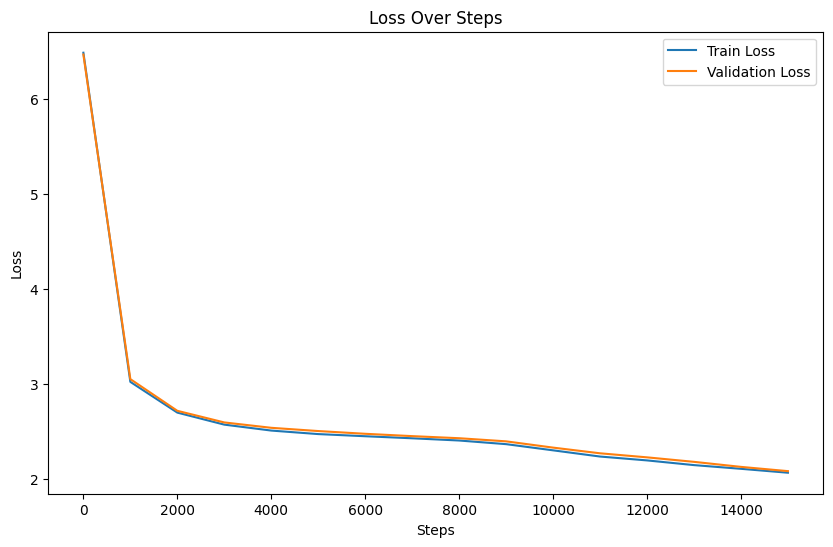

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# saving the model
torch.save(model.state_dict(), 'transformer_model.pth')

In [18]:
ffn_factor = 6
embedding_params = n_embd * vocab_size
attention_params = n_head * (n_embd // n_head * 2 * n_embd) * n_layer

feedforward_params = n_embd * ffn_factor * n_layer * 2
total_params = embedding_params + attention_params + feedforward_params

In [19]:
# summary
print('//// Summary ////')
print(f"total no of words in the file: {total_no_of_words / 1e6} million")
print(f"total predicted parameters: {total_params / 1e6} million")
print(f"actual no of parameters: {n_param} million")
print(f"total time taken to run the model was {total_time / 3600} hrs")
print(f"model ran for {max_iters} iterations and final val loss: {val_losses[-1]} and train loss: {train_losses[-1]}")
print('\n')
print("/// output ///")
print(f"I gave input text as: '{input_from_user}'")
print(f"generated output was {generated_output}")

//// Summary ////
total no of words in the file: 397.043001 million
total predicted parameters: 4.3659 million
actual no of parameters: 25.043122 million
total time taken to run the model was 3.2263192910122225 hrs
model ran for 15000 iterations and final val loss: 2.085087299346924 and train loss: 2.068484306335449


/// output ///
I gave input text as: 'people often lie about themselves but'
generated output was people often lie about themselves butersowers in thickins wachat ot it'm liketis emy he herener the serandsct por sto goons o ad lingeny o oit seise to sakesendes hir xcrs asow end frimite tὙo it Po anies dit wetes wit itt he've don's il theokere ande ithit des un han'ld oust fnelilyping us doildsudy thing line di's t wank sesilin a t i an wik forar tof as sdecus wiskn guster rep unod pere evald iny tout she umaguty Avoks soal n wit'


In [ ]:
from google.colab import files
files.download('transformer_model.pth')